# Basic Linear Regression: Finding lines that explain our data
## Machine learning for medicine (MedML@Emory) Workshop 
Authors: Vineet Tiruvadi, Alex Milani, Avinash Murugan





## Overview
'Linear regression' is a fancy way of saying we're going to see if a line can be drawn neatly between two variables we care about.
Linear regression is the workhorse of almost all of the statistics we learn, especially the statistics in 'evidence-based medicine' courses taught in medical school.
But linear regression is also the foundation of **Machine Learning**.

In this notebook, we're going to cover the basics of linear regression in an interactive, medically-motivated format.
We'll spend most of our time covering 2-D linear regression (independent variable X and dependent variable Y).

Outline:
* Code setup
  * Skip if you're not ready to dive into Python code
* A 2-dimensional linear regression
  * Defining our 'true' relationship
  * Generating our dataset
* See how effect size affects the regression
* A 3-dimensional linear regression

## License
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Intro

Let's start with a simple (silly) example:

<center><img src="https://vineet.tiruvadi.com/egg_basic_LR.png" alt="Drawing" height=600/></center>

This is a (imaginary) experiment we ran.
We cooked 100 eggs for different amounts of time and rated their deliciousness.
We built a linear regression model (blue line) that does a good job of 'fitting' our data and, importantly, 'summarized' our results: more cooking = more delicious.

**The red line is the "true" relationship and it looks like our blue line might start being wrong if we cook for much longer than 5 minutes...**
Linear regression has several major limitations which modern ML does a fantastic job of accounting for.
We'll cover these in later notebooks.

Let's get our coding-space up and running by importing the Python libraries we're going to be working with.

### Code Setup

In [ ]:
# The big library for doing math + data in python
import numpy as np
np.random.seed(1111)

# A big library that has a lot of useful functions for scientific use of python
import scipy

# The main library for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
matplotlib.rcParams['figure.figsize'] = [15, 10]

# The main library used for statistics
import scipy.stats as stats
import pandas
from pandas import DataFrame
import plotly.express as px


# Libraries that let us use interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits import mplot3d

# Misc stuff related to cleaning up code and displaying results in a pretty way
from IPython.display import Markdown as md

# The library we're going to use for our linear regression
import sklearn
import sklearn.linear_model
from sklearn.linear_model import LinearRegression


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Simulated Data
def get_our_data(true_relationship,noise=20,num_pts = 10):
  # the ground truth
  
  # The data we (simulated) collected from patients
  exp_1_a1c = np.random.uniform(0,15,size=(num_pts,1))
  exp_1_lrcv = true_relationship * exp_1_a1c + np.random.normal(0,noise,size=(num_pts,1))

  x = exp_1_a1c.reshape(-1,1)
  y = exp_1_lrcv.reshape(-1,1)

  return x,y,true_relationship

In [ ]:
#### General Functions
truth = lambda x,slope: slope * x
# TODO RANDOM SEED FIXED

def gen_lin_data(factor,noise,samples):
    x = np.random.uniform(-10,10,size=(samples,)).reshape(-1,1)
    y = truth(x,factor) + np.random.normal(0,noise,size=x.shape)
    
    return x,y

def simple_eg(slope=1.0,noise=0.0,samples=100):
    x,y = gen_lin_data(slope,noise,samples)
    #x = np.random.uniform(-10,10,size=(samples,))
    #y = slope * x + np.random.normal(0,noise,size=x.shape)

    reg = LinearRegression(fit_intercept=False).fit(x, y)
    reg.score(exp_1_a1c, exp_1_lrcv)
    slope_estimate = reg.coef_[0,0]

    plt.figure()
    plt.scatter(x,y)
    #plt.scatter(x,np.random.normal(0,noise,size=x.shape),color='red',alpha=0.4)
    x_fix = np.linspace(-10,10,100)
    plt.plot(x_fix,slope * x_fix,'--',label='True')
    plt.plot(x_fix,slope_estimate * x_fix + reg.intercept_,label='Regression')
    #plt.text(3,80,'Estimated slope: ' + str(np.round(slope_estimate,4)),color='red')

    plt.legend()

    plt.xlim(-10,10)
    plt.ylim(-50,50)
    #plt.axis('off')

    plt.title('Regression slope is ' + str(reg.coef_[0,0]))
    plt.suptitle('True slope is ' + str(slope))
  
    corr_val = stats.pearsonr(x.squeeze(),y.squeeze())
    plt.text(2,-10,s='Pearson: ' + str(corr_val[0]) + '\n p=' + str(corr_val[1]))
    plt.show()

In [ ]:
# Plotting
def plot_data(a1c,bgluc,truth):
    plt.figure()
    plt.scatter(a1c,bgluc)
    plt.xlabel('Measured A1c')
    plt.ylabel('Lifetime risk of CV disease')
    plt.xlim((0,15))
    plt.ylim((0,100))
    plt.title('True relationship is ' + str(truth))

## Background
Lines are really useful as tools to figure out how things are related with each other.
Linear regression is a fancy way of saying: let's find lines between variables that tell us how they affect each, and its a major workhorse in statistics.
Maybe surprisingly, almost all of EBM taught in medical school is just individual special cases of linear regression.

What we're doing here is opening up the hood of EBM but it's also showing us the engine of machine learning.
We'll be returning to the idea of linear regression again and again.

## Linear Regression (2D)
First, we're going to fit lines to datapoints in a straightforward plot.

Let's dive into a hands on example.

### Diabetes and lifetime Cardiovascular Risk

We know diabetes is bad.
We suspect that patients with diabetes have higher risk of cardiovascular disease.
We know patients with diabetes tend to have more lifelong complications, especially with their cardiovascular system.
We also know that the severity of the diabetes is related to the Hemoglobin A1c, a measure of the 'average' glucose concentration in the blood over the last few months.


Let's try to find this relationship between the A1c and lifetime risk of cardiovascular disease.

<align >
**Reminder: This is a simulated dataset**
</right>

### Defining our *true* relationship: The thing we're trying to infer (SKIP)


In [ ]:
truth_slider = widgets.FloatSlider(min=3,max=5,description="Truth",value=4.0)
display(truth_slider)
## TODO MAKE IT AUTOMAGICALLY UPDATE

FloatSlider(value=4.0, description='Truth', max=5.0, min=3.0)

First, for this exercise, we will define the *true* relationship between A1c and lifetime risk: 

$$ \text{lifetime_risk_CV} = 4 * \text{Hg}_{A1c}$$

The goal of ML (and EBM in general) is to get to this truth *through the data*.
This is called *inference*.

Let's set our relationship to the value we want: 4

### Data generated by the thing we're trying to infer
Truth -> Experiment -> Data

All good data comes from an experiment.
In our case we 'simulated' an experiment, but let's take a look at the 'simulated' data that the experiment generated.
Think of this as simulated 'blood draws' from a set of patients that we're then going to try to predict their lifetime CV risk from only their A1c.


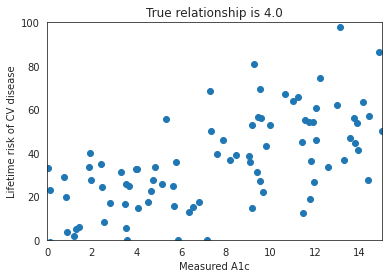

In [ ]:
## THIS GENERATES OUR DATA
true_relationship = truth_slider.value
exp_1_a1c,exp_1_lrcv,slope = get_our_data(true_relationship = true_relationship,num_pts=100)

plot_data(exp_1_a1c,exp_1_lrcv,true_relationship)

## Training a regression model to 'guess' the true relationship
Let's now use linear regression to try to guess the true relationship between A1c and lifetime CV risk.

In [ ]:
## DO REGRESSION
# We set up our linear regression here
reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(exp_1_a1c, exp_1_lrcv)
reg.score(exp_1_a1c, exp_1_lrcv) # This gives us a 'score' for how well our model fits the data
slope_estimate = reg.coef_[0,0] # This finds the *slope* in our model's set of coefficients


### Plotting our model with data

Regression slope is 3.956779735829705
How close are we to the true slope, which we set above at 4.0 ?


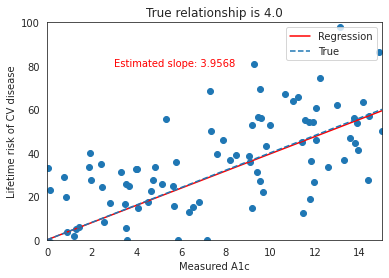

In [ ]:
# Plotting the Model we learned from our Data
# First we'll plot our data, just like above, so we can display our regression model over it
plot_data(exp_1_a1c,exp_1_lrcv,true_relationship)

#Now let's plot the lines that we think link our variables
x_fix = np.linspace(0,15,100)
plt.plot(x_fix,slope_estimate * x_fix + reg.intercept_,'red',label='Regression')
plt.text(3,80,'Estimated slope: ' + str(np.round(slope_estimate,4)),color='red')
plt.plot(x_fix,slope * x_fix,'--',label='True')
plt.legend()


print('Regression slope is ' + str(reg.coef_[0,0]))
print("How close are we to the true slope, which we set above at " + str(np.round(slope,4)) + " ?")

The goal in any linear regression is to *figure out* what the true conversion-factor is using the *data*.
The conversion-factor is nothing more than a number that tells us "how much does lifetime risk of CV-disease increase when you increase the A1c by 1".
This is what we call *slope*.

What we did here was let the computer find us a line that "best" fit our data and then have it tell us what the slope of that line was.
Even if it's not perfect, the linear regression approach let us see that there's an *association* between the two variable.

**In the real world** we don't know the 'true' blue line, we only have the red line.
That's where science begins!


## The effect of sample size
We're taught that larger samples sizes are good.
This is (generally) true, so let's see this in action.

1) Set the noise low then see how decreasing the sample size hurts your regression's 'guess' of the slope.

2) Then, with the sample size low, increase the noise and see how off the 'guess' goes.

3) Move the samples slider up and see how the 'guess' starts becoming closer to the true value again.

In [ ]:
## THIS IS WHERE WE SEE HOW NOISE and SAMPLES affect our ability to do _good_ regression
widg = interactive(simple_eg,slope=fixed(true_relationship),noise=(0.0,25.0,1.0),samples=(2,200,1))
display(widg)

interactive(children=(FloatSlider(value=0.0, description='noise', max=25.0, step=1.0), IntSlider(value=100, de…

## Signal-to-noise ratio: Slope overcomes noise

Next we're going to adjust the slope of our line, or *how strong the relationship between the two variables is* and see how this affects our ability to do a simple regression.


In [ ]:
widg = interactive(simple_eg,slope=(0.0,10.0,0.05),noise=(0.0,25.0,1.0),samples=(2,200,1))
display(widg)

interactive(children=(FloatSlider(value=1.0, description='slope', max=10.0, step=0.05), FloatSlider(value=0.0,…

### Breaking down the example
Let's pause and talk about what we're seeing above.

First, you'll see a set of blue dots: this is our *data*.
There's a red line there that is our *regression model*.

If you increase the noise a bit you'll see another line: a *dotted blue line* which is our *truth*.
We can adjust our truth by adjusting the 'slope' slider.
The noise adds 'static' into our simulated data.

### From good to bad regressions
Noise is what comes in and makes our jobs difficult as scientists.
Noise is what masks the 'real relationship' and can come from multiple sources: measurement device, confounding variables, bias, etc.
Noise gets in the way of *signal* which is what we're interested in studying (by definition).

This gets us to the idea of 'signal-to-noise' ratio.
This is analogous to 'effect size' but becomes a much bigger concept in ML/engineering.

Try it our yourself:
1) Fix the slope to something like 1.0,
2) increase the noise to 15.0 while keeping the samples to ~5.
3) See what happens to your regression line.
4) Then, move just the slope up to 10 and see what happens to the regression line.

This is similar to a 'power analysis' where you figure out how many samples you need to be able to confidently say "y is related to x, even though there is noise".

### Pearson Correlation
An important point that you should keep in mind - The Pearson Correlation and the slope of the regression line are not the same.
The slope of the regression line tells us the relationship between x and y, the relationship that we are interested in.
The Pearson Correlation tells us how closely the two values align.

Try if yourself: 
1) set the noise=0 
2) then lower the slope to ~0.01 and see that the linear regression model follows but the Pearson Correlation stays ~1.0 = 100%


## Three-dimensional regression

Doing regression in 2-dimensions is just scratching the surface.
This basic idea is the foundation of ML, ML just takes this to very high dimensions and for relationships that *aren't* lines.

#### Interactive Example
The variables we're going to look at are related this way:
$ y = 0.2 \cdot x + 10 \cdot w$




In [ ]:
true_slope = [0.2,-3]
model = np.array(true_slope).reshape(-1,1)

noise_slider = widgets.FloatSlider(min=0.0,max=10.0,description="Noise")
display(noise_slider)


FloatSlider(value=0.0, description='Noise', max=10.0)

In [ ]:
#If you edit the noise slider, please re-run this cell to re-plot

# TODO Plane
def run_3d(noise):
  pt_num = 100
  x = np.random.uniform(-10,10,size=(pt_num,2))
  y = np.dot(x,model)
  y += np.random.normal(0,noise,size=y.shape)
  data = np.hstack((x,y))
  dats = {'x':data[:,0].squeeze(),'w':data[:,1].squeeze(),'y':data[:,2].squeeze()}
  df = DataFrame(data=dats)

  fig = px.scatter_3d(df, x='x', y='w', z='y',width=1200, height=1200)
  view_range=[-10,10]
  fig.update_layout(scene=dict(xaxis=dict(range=view_range),yaxis=dict(range=view_range),zaxis=dict(range=view_range),aspectmode="cube"))
  fig['layout'].update(width=700, height=700, autosize=False)
  fig.show()

  model_3d = LinearRegression(fit_intercept=True).fit(x, y)
  model_3d.score(x, y) #This gives us a 'score' that tells us how well the model did

  return model_3d.coef_

model_estimate = run_3d(noise=noise_slider.value)
print('Estimated slope is ' + str(model_estimate))

Estimated slope is [[ 0.2 -3. ]]


## Parting thoughts and big picture

In this notebook we interactive learned about 2-d linear regression.

You may ask yourself: what's the big deal about ML if we're learning about linear regression?
It's just a line?

Turns out this is the basic building block of the vast majority of ML.
Lienar regression in 2D is relatively 'easy'.
But we can also do linear regression in 3 dimensions, 4 dimensions, 20 dimensions, 100000 dimensions.
That's where we start getting into some real ML.

### Patient Example
Using the example from our workshop (5/22; accompanying video [here]()):

What we did above was like focusing on how a single lab value, like Serum Sodium (Na), related to long-term prognosis.
But we know that the other electrolytes and lab values *also* relate to health.
What ML can enable us to do is to study *all the electrolytes* together in an experiment instead of running separate experiments for each electrolyte.
This is *huge* for both scientific understanding, for economic cost, and for patient care.

![](https://vineet.tiruvadi.com/na_pt.png)

In the next regression notebook we'll ramp things up into *multidimensional* regression.
We're going to look at several different *factors* (literally, it's on coagulation cascade) and use the data to 'infer' something.
Since we already know the coagulation cascade, we can compare how well our data-driven (ML) approach did.
Head on over to our [advanced linear regression notebooks](https://colab.research.google.com/drive/1vsyYjRdavXORxEYQXDNMtdYZBnr7Qdxt?usp=sharing)).

Thanks for working through this notebook with us!

-MedML


Copyright 2020 MedML